# Network Distance with LION map (weight)
We will attempt to use networkx library with the lion map to calculate network distance for people walking between two points.
What I learned:
- weights need to be specified in order to calculate the right shortest_path
- edges between nodes do not have have physical distance unless you specify the attribute in the edges

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import box, LineString, Point,MultiPoint
import os
import sys
import fiona
import numpy as np

sys.path.append(os.path.realpath('..'))

In [2]:
print(fiona.__version__)

1.8.4


In [3]:
print(nx.__version__)

2.3


## Load Lion

In [4]:
shp_file = r"../intermediate_data/lion_gdf2012/lion_gdf2012.shp"

lion_shp = gpd.read_file(shp_file)
lion_graph = nx.read_shp(shp_file, simplify=False)

In [5]:
G = lion_graph.to_undirected()
nodeslist = list(G.nodes)
G = nx.convert_node_labels_to_integers(G, first_label = 0)
nodesnumlist = list(G.nodes)

Create a nodes geopandas dataframe so that we can extract the geometries later

In [6]:
node_df = pd.DataFrame(list(zip(nodesnumlist, nodeslist)), 
               columns =['node_id', 'geometry'])

In [7]:
node_df['geometry'] = node_df['geometry'].apply(Point)

In [8]:
node_gdf = gpd.GeoDataFrame(node_df, geometry='geometry')
node_gdf.crs = {'init': 'epsg:4326'}

Examine the attributes of the edges. Locate the variable that gives the distance of the edge

In [9]:
list(G.edges(data=True))[0]

(0,
 1,
 {'Street': 'EAST 168 STREET',
  'SAFStreetN': None,
  'FeatureTyp': '0',
  'SegmentTyp': 'U',
  'IncExFlag': None,
  'RB_Layer': 'B',
  'NonPed': None,
  'TrafDir': 'T',
  'TrafSrc': 'DOT',
  'SpecAddr': None,
  'FaceCode': '2510',
  'SeqNum': '03070',
  'StreetCode': '226700',
  'SAFStreetC': None,
  'LGC1': '01',
  'LGC2': None,
  'LGC3': None,
  'LGC4': None,
  'LGC5': None,
  'LGC6': None,
  'LGC7': None,
  'LGC8': None,
  'LGC9': None,
  'BOE_LGC': '1',
  'SegmentID': '0078126',
  'SegCount': '1',
  'LocStatus': 'X',
  'LZip': '10456',
  'RZip': '10456',
  'LBoro': 2.0,
  'RBoro': 2.0,
  'L_CD': '203',
  'R_CD': '203',
  'LATOMICPOL': '401',
  'RATOMICPOL': '101',
  'LCT2010': '149',
  'LCT2010Suf': None,
  'RCT2010': '185',
  'RCT2010Suf': None,
  'LCB2010': '3001',
  'LCB2010Suf': None,
  'RCB2010': '2000',
  'RCB2010Suf': None,
  'LCT2000': '149',
  'LCT2000Suf': None,
  'RCT2000': '137',
  'RCT2000Suf': None,
  'LCB2000': '4000',
  'LCB2000Suf': None,
  'RCB2000': '10

In [10]:
node_gdf.count()

node_id     174251
geometry    174251
dtype: int64

In [11]:
lion_shp.crs = {'init': 'epsg:4326'}
node_gdf.crs = {'init': 'epsg:4326'}

## Network analysis!

In [82]:
orig_node = 36640
target_node = 34029

To calculate shortest path network distance, we have to specify the weight. Here weight is defined as `SHAPE_Leng` - the length provided by LION.

If we do not specify the weight, we might get the longer path.

In [83]:
route = nx.shortest_path(G=G, source=orig_node, target=target_node, weight = None)

In [84]:
route_nodes = node_gdf.loc[route]
route_line = LineString(list(route_nodes.geometry.values))

Make a geodataframe to store the data

In [85]:
route_geom = gpd.GeoDataFrame(crs=node_gdf.crs)
route_geom['geometry'] = None
route_geom['id'] = None

Add the information into the geodataframe

In [86]:
route_geom.loc[0, 'geometry'] = route_line
route_geom.loc[0, 'id'] = str(list(route_nodes['node_id'].values))

Specifying the weight as the length of the edge

In [87]:
route = nx.shortest_path(G=G, source=orig_node, target=target_node, weight = 'SHAPE_Leng')

Capture the route nodes and turn it into a `LineString`

In [88]:
route_nodes = node_gdf.loc[route]
route_line = LineString(list(route_nodes.geometry.values))

Add the information into the geodataframe

In [89]:
route_geom.loc[1, 'geometry'] = route_line
route_geom.loc[1, 'id'] = str(list(route_nodes['node_id'].values))

In [92]:
route_geom.head()

,geometry,id
0,LINESTRING (-73.87934833267502 40.655788576932...,"[36640, 44476, 48098, 41035, 41036, 44649, 573..."
1,LINESTRING (-73.87934833267502 40.655788576932...,"[36640, 44476, 48098, 41035, 57356, 57357, 573..."


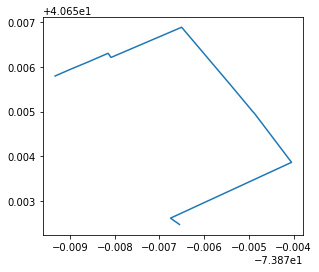

In [93]:
route_geom.loc[[0],'geometry'].plot();

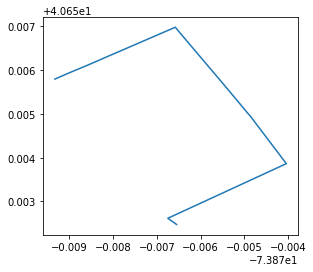

In [94]:
route_geom.loc[[1],'geometry'].plot();

## Printing the route/edge using the bbox of the route_geom

In [95]:
bounding_box = route_geom.envelope
df = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])

In [96]:
df['bbox'] = 1
df.crs = {'init': 'epsg:4326'}

In [97]:
join_left_df = gpd.sjoin(lion_shp, df, how="left")

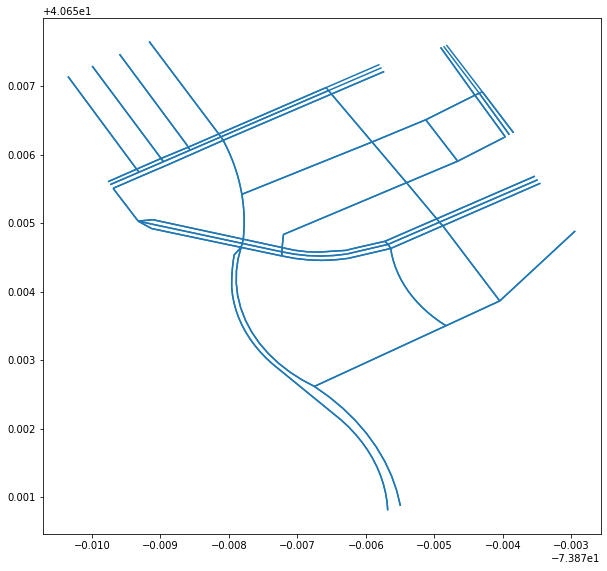

In [98]:
join_left_df.loc[join_left_df['bbox'] == 1].plot(figsize = (10,10))

## Overlaying the route on top of the edge lines

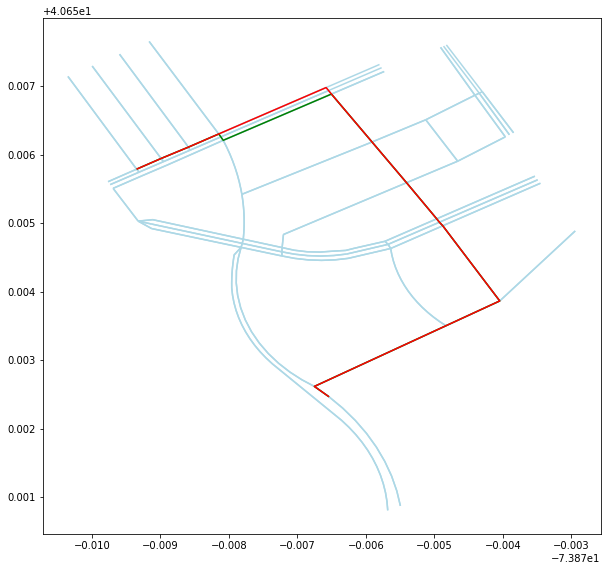

In [99]:
base = join_left_df.loc[join_left_df['bbox'] == 1].plot(figsize = (10,10), color = 'lightblue')
#route_geom.plot(ax=base, color='red');
route_geom.loc[[0],'geometry'].plot(ax=base, color='green');
route_geom.loc[[1],'geometry'].plot(ax=base, color='red');

## The green route was selected by networkx when no weights was specified. The red route was selected by networkx with the weights specified as length. 

In [62]:
(lion_shp['SHAPE_Leng'] > 0).value_counts()

True    149348
Name: SHAPE_Leng, dtype: int64

In [65]:
lion_shp['SHAPE_Leng'].isnull().value_counts()

False    149348
Name: SHAPE_Leng, dtype: int64